In [1]:
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import selectivesearch


{(0, 0, 4031, 3023),
 (318, 158, 1484, 2761),
 (318, 158, 2607, 2761),
 (318, 158, 3504, 2761),
 (326, 167, 3496, 2746),
 (570, 321, 758, 499),
 (570, 321, 758, 502),
 (570, 324, 758, 496),
 (681, 2151, 771, 513),
 (714, 1048, 655, 359),
 (735, 1212, 172, 167),
 (848, 1657, 376, 251),
 (848, 1657, 377, 251),
 (1091, 1209, 169, 167),
 (1558, 1724, 647, 252),
 (1565, 1703, 745, 266),
 (1568, 190, 2262, 2692),
 (1568, 190, 2267, 2692),
 (1630, 1015, 417, 252),
 (1684, 352, 259, 270),
 (1684, 352, 259, 276),
 (1696, 2229, 484, 437),
 (1696, 2229, 484, 441),
 (1869, 1200, 53, 51),
 (2238, 1797, 69, 97),
 (2440, 228, 1390, 2654),
 (2440, 1000, 226, 625),
 (2440, 1000, 904, 690),
 (2440, 1000, 1343, 696),
 (2466, 228, 1364, 2654),
 (2466, 453, 331, 239),
 (2470, 1116, 201, 147),
 (2497, 1011, 1281, 677),
 (2497, 1011, 1281, 678),
 (2592, 228, 1238, 2654),
 (2674, 1325, 145, 60),
 (2704, 1519, 199, 102),
 (2714, 1519, 189, 102),
 (2729, 1132, 66, 71),
 (2748, 2386, 570, 257),
 (2748, 2466, 62,

In [2]:
def read_image(image_path):
    img = io.imread(image_path)
    return img

{(0, 0, 4031, 3023),
 (318, 158, 1484, 2761),
 (318, 158, 2607, 2761),
 (318, 158, 3504, 2761),
 (326, 167, 3496, 2746),
 (570, 321, 758, 499),
 (570, 321, 758, 502),
 (570, 324, 758, 496),
 (681, 2151, 771, 513),
 (714, 1048, 655, 359),
 (735, 1212, 172, 167),
 (848, 1657, 376, 251),
 (848, 1657, 377, 251),
 (1091, 1209, 169, 167),
 (1558, 1724, 647, 252),
 (1565, 1703, 745, 266),
 (1568, 190, 2262, 2692),
 (1568, 190, 2267, 2692),
 (1630, 1015, 417, 252),
 (1684, 352, 259, 270),
 (1684, 352, 259, 276),
 (1696, 2229, 484, 437),
 (1696, 2229, 484, 441),
 (1869, 1200, 53, 51),
 (2238, 1797, 69, 97),
 (2440, 228, 1390, 2654),
 (2440, 1000, 226, 625),
 (2440, 1000, 904, 690),
 (2440, 1000, 1343, 696),
 (2466, 228, 1364, 2654),
 (2466, 453, 331, 239),
 (2470, 1116, 201, 147),
 (2497, 1011, 1281, 677),
 (2497, 1011, 1281, 678),
 (2592, 228, 1238, 2654),
 (2674, 1325, 145, 60),
 (2704, 1519, 199, 102),
 (2714, 1519, 189, 102),
 (2729, 1132, 66, 71),
 (2748, 2386, 570, 257),
 (2748, 2466, 62,

In [3]:
def get_component_position(img):
    # perform selective search
    img_lbl, regions = selectivesearch.selective_search(
        img, scale=5000, sigma=0.9, min_size=10)

    candidates = set()
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 2000:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if w / h > 3 or h / w > 3:
            continue
        candidates.add(r['rect'])

    return candidates


{(0, 0, 4031, 3023),
 (318, 158, 1484, 2761),
 (318, 158, 2607, 2761),
 (318, 158, 3504, 2761),
 (326, 167, 3496, 2746),
 (570, 321, 758, 499),
 (570, 321, 758, 502),
 (570, 324, 758, 496),
 (681, 2151, 771, 513),
 (714, 1048, 655, 359),
 (735, 1212, 172, 167),
 (848, 1657, 376, 251),
 (848, 1657, 377, 251),
 (1091, 1209, 169, 167),
 (1558, 1724, 647, 252),
 (1565, 1703, 745, 266),
 (1568, 190, 2262, 2692),
 (1568, 190, 2267, 2692),
 (1630, 1015, 417, 252),
 (1684, 352, 259, 270),
 (1684, 352, 259, 276),
 (1696, 2229, 484, 437),
 (1696, 2229, 484, 441),
 (1869, 1200, 53, 51),
 (2238, 1797, 69, 97),
 (2440, 228, 1390, 2654),
 (2440, 1000, 226, 625),
 (2440, 1000, 904, 690),
 (2440, 1000, 1343, 696),
 (2466, 228, 1364, 2654),
 (2466, 453, 331, 239),
 (2470, 1116, 201, 147),
 (2497, 1011, 1281, 677),
 (2497, 1011, 1281, 678),
 (2592, 228, 1238, 2654),
 (2674, 1325, 145, 60),
 (2704, 1519, 199, 102),
 (2714, 1519, 189, 102),
 (2729, 1132, 66, 71),
 (2748, 2386, 570, 257),
 (2748, 2466, 62,

In [4]:
img_path = r'C:\Users\bunny\Desktop\IMG_1278.JPG'
image = read_image(img_path)


{(0, 0, 4031, 3023),
 (318, 158, 1484, 2761),
 (318, 158, 2607, 2761),
 (318, 158, 3504, 2761),
 (326, 167, 3496, 2746),
 (570, 321, 758, 499),
 (570, 321, 758, 502),
 (570, 324, 758, 496),
 (681, 2151, 771, 513),
 (714, 1048, 655, 359),
 (735, 1212, 172, 167),
 (848, 1657, 376, 251),
 (848, 1657, 377, 251),
 (1091, 1209, 169, 167),
 (1558, 1724, 647, 252),
 (1565, 1703, 745, 266),
 (1568, 190, 2262, 2692),
 (1568, 190, 2267, 2692),
 (1630, 1015, 417, 252),
 (1684, 352, 259, 270),
 (1684, 352, 259, 276),
 (1696, 2229, 484, 437),
 (1696, 2229, 484, 441),
 (1869, 1200, 53, 51),
 (2238, 1797, 69, 97),
 (2440, 228, 1390, 2654),
 (2440, 1000, 226, 625),
 (2440, 1000, 904, 690),
 (2440, 1000, 1343, 696),
 (2466, 228, 1364, 2654),
 (2466, 453, 331, 239),
 (2470, 1116, 201, 147),
 (2497, 1011, 1281, 677),
 (2497, 1011, 1281, 678),
 (2592, 228, 1238, 2654),
 (2674, 1325, 145, 60),
 (2704, 1519, 199, 102),
 (2714, 1519, 189, 102),
 (2729, 1132, 66, 71),
 (2748, 2386, 570, 257),
 (2748, 2466, 62,

In [5]:
blocks = get_component_position(image)
blocks


{(0, 0, 4031, 3023),
 (318, 158, 1484, 2761),
 (318, 158, 2607, 2761),
 (318, 158, 3504, 2761),
 (326, 167, 3496, 2746),
 (570, 321, 758, 499),
 (570, 321, 758, 502),
 (570, 324, 758, 496),
 (681, 2151, 771, 513),
 (714, 1048, 655, 359),
 (735, 1212, 172, 167),
 (848, 1657, 376, 251),
 (848, 1657, 377, 251),
 (1091, 1209, 169, 167),
 (1558, 1724, 647, 252),
 (1565, 1703, 745, 266),
 (1568, 190, 2262, 2692),
 (1568, 190, 2267, 2692),
 (1630, 1015, 417, 252),
 (1684, 352, 259, 270),
 (1684, 352, 259, 276),
 (1696, 2229, 484, 437),
 (1696, 2229, 484, 441),
 (1869, 1200, 53, 51),
 (2238, 1797, 69, 97),
 (2440, 228, 1390, 2654),
 (2440, 1000, 226, 625),
 (2440, 1000, 904, 690),
 (2440, 1000, 1343, 696),
 (2466, 228, 1364, 2654),
 (2466, 453, 331, 239),
 (2470, 1116, 201, 147),
 (2497, 1011, 1281, 677),
 (2497, 1011, 1281, 678),
 (2592, 228, 1238, 2654),
 (2674, 1325, 145, 60),
 (2704, 1519, 199, 102),
 (2714, 1519, 189, 102),
 (2729, 1132, 66, 71),
 (2748, 2386, 570, 257),
 (2748, 2466, 62,

In [6]:
h_aver = sum([group[3] for group in blocks])/len(blocks)
h_aver

753.051724137931

In [7]:
w_aver = sum([group[2] for group in blocks])/len(blocks)
w_aver

800.9310344827586

In [8]:
size_index = 1.75
filtered_blocks = [group for group in blocks if (group[2] <= w_aver * size_index and group[3] <= h_aver * size_index)]
filtered_blocks


[(2440, 1000, 226, 625),
 (848, 1657, 377, 251),
 (3053, 403, 392, 331),
 (1684, 352, 259, 276),
 (570, 321, 758, 502),
 (3092, 1015, 691, 681),
 (570, 321, 758, 499),
 (714, 1048, 655, 359),
 (2986, 419, 456, 403),
 (2466, 453, 331, 239),
 (1696, 2229, 484, 437),
 (2986, 419, 456, 348),
 (2986, 419, 458, 403),
 (3065, 403, 380, 331),
 (1684, 352, 259, 270),
 (1696, 2229, 484, 441),
 (2944, 1008, 839, 688),
 (2440, 1000, 1343, 696),
 (1869, 1200, 53, 51),
 (1630, 1015, 417, 252),
 (3022, 403, 423, 333),
 (735, 1212, 172, 167),
 (2704, 1519, 199, 102),
 (2748, 2466, 62, 116),
 (848, 1657, 376, 251),
 (3360, 1474, 100, 39),
 (1558, 1724, 647, 252),
 (2674, 1325, 145, 60),
 (2894, 1929, 308, 238),
 (570, 324, 758, 496),
 (3212, 1456, 84, 58),
 (2714, 1519, 189, 102),
 (1565, 1703, 745, 266),
 (2887, 1008, 896, 688),
 (2772, 2386, 546, 257),
 (2748, 2386, 570, 257),
 (2944, 1015, 839, 681),
 (3055, 403, 390, 331),
 (2440, 1000, 904, 690),
 (2497, 1011, 1281, 677),
 (2810, 1472, 85, 43),
 (

In [9]:
%matplotlib inline
def draw_image(img, block_candidates):
    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img)
    for x, y, w, h in block_candidates:
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()


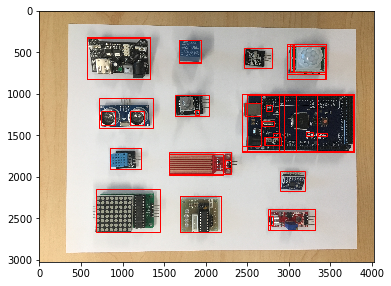

In [10]:
draw_image(image, filtered_blocks)

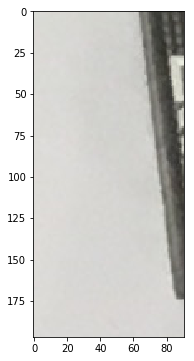

In [11]:
#(556, 569, 91, 197)
submatrix = image[569:569+197,556:556+91]
draw_image(submatrix, [])

In [12]:
from skimage import transform
if submatrix.shape[2] == 4:
    submatrix = submatrix[:, :, :3]
submatrix = transform.resize(submatrix, (200, 200))
draw_image(submatrix, [])


C:\Users\bunny\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [13]:
w = 200
h = 200
c = 3

sub_images = []
for block in filtered_blocks:
    _x = block[0]
    _y = block[1]
    _w = block[2]
    _h = block[3]
    sub_image = image[_y:_y + _h, _x:_x + _w]
    if sub_image.shape[2] == 4:
        sub_image = sub_image[:, :, :3]
    sub_image = transform.resize(sub_image, (w, h))
    sub_images.append(sub_image)

C:\Users\bunny\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [14]:
from tensorflow import keras
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.models import Sequential


input_shape = (w, h, c)
learning_rate = 0.0001
regularization_rate = 0.0001
category_count = 13 + 1


array([12, 11,  5,  7,  3,  4,  3, 12,  5,  2, 10,  5,  5,  5,  7, 10,  4,
        4, 13, 12,  5,  1, 10,  0, 11,  9, 13, 13,  2,  3,  5,  1, 13,  4,
        9,  9,  4,  5,  4,  4,  1,  4,  2,  3, 13,  0,  9,  5],
      dtype=int64)

In [15]:
from keras.models import load_model

train_path = r'C:\Users\bunny\Desktop\mega_2560_cat\TRAIN/'
model = load_model(train_path + '/model.h5')

array([12, 11,  5,  7,  3,  4,  3, 12,  5,  2, 10,  5,  5,  5,  7, 10,  4,
        4, 13, 12,  5,  1, 10,  0, 11,  9, 13, 13,  2,  3,  5,  1, 13,  4,
        9,  9,  4,  5,  4,  4,  1,  4,  2,  3, 13,  0,  9,  5],
      dtype=int64)

In [16]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


array([12, 11,  5,  7,  3,  4,  3, 12,  5,  2, 10,  5,  5,  5,  7, 10,  4,
        4, 13, 12,  5,  1, 10,  0, 11,  9, 13, 13,  2,  3,  5,  1, 13,  4,
        9,  9,  4,  5,  4,  4,  1,  4,  2,  3, 13,  0,  9,  5],
      dtype=int64)

In [17]:
import numpy as np
cat = model.predict_classes(np.asarray(sub_images, np.float32))
cat


array([12, 11,  5,  7,  3,  4,  3, 12,  5,  2, 10,  5,  5,  5,  7, 10,  4,
        4, 13, 12,  5,  1, 10,  0, 11,  9, 13, 13,  2,  3,  5,  1, 13,  4,
        9,  9,  4,  5,  4,  4,  1,  4,  2,  3, 13,  0,  9,  5],
      dtype=int64)

In [18]:
cat_list = [
    "blank",
    "gy-521_module",
    "ir_receiver_module",
    "max7219_module",
    "mega2560_controller_board",
    "pir_motion_sensor_HC-SR501",
    "power_supply_module",
    "relay_5v",
    "rotary_encoder_module",
    "sound_sensor_module",
    "stepper_motor_driver_board_uln2003",
    "temperature_and_humidity_module_DHT11",
    "ultrasonic_sensor",
    "water_level_detection_sensor_module",
]


In [23]:
%matplotlib inline
def draw_name_on_image(img, block_candidates):
    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 20))
    plt.imshow(img)
    for x, y, w, h in block_candidates:
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
    for block in block_candidates:
        x = block[0]
        y = block[1]
        index = block_candidates.index(block)
        plt.text(x,y,cat_list[cat[index]], color = 'green', fontsize = 16)

    plt.show()
    fig.savefig("test.png")


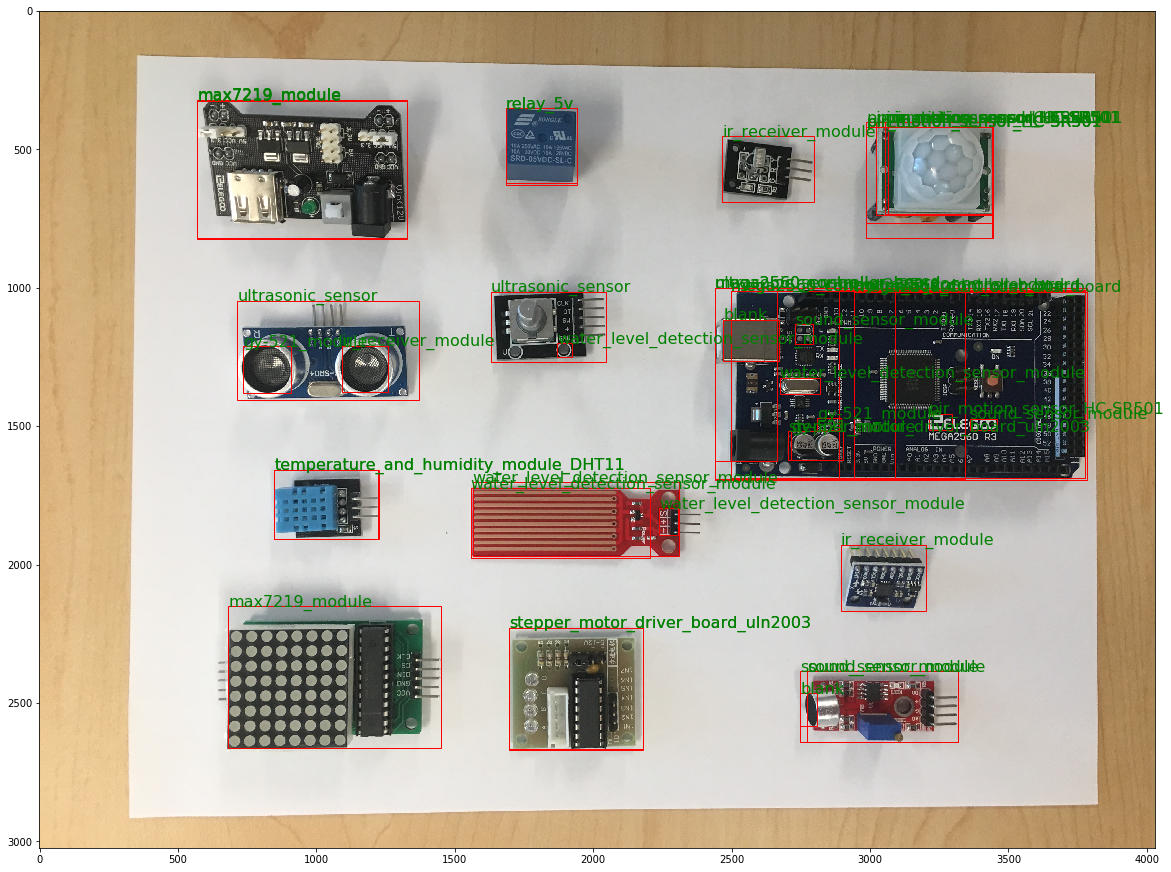

In [24]:
draw_name_on_image(image, filtered_blocks)